<h1><center>Laboratorio 7: La desperación de Mr. Lepin 🐼</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla, Ignacio Meza
- Auxiliar: Sebastián Tinoco
- Ayudante: Felipe Arias, Diego Cortez

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Raimundo Sandoval
- Nombre de alumno 2: Cristóbal Subiabre


### **Link de repositorio de GitHub:** `http://https://github.com/raisando/Laboratorio-MDS7202-`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

# Temas a tratar

- Aplicar Pandas para obtener características de un DataFrame.
- Aplicar Pipelines.
- Aplicar Clusters sobre un conjunto de datos.

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Comprender y aprovechar las ventajas que nos ofrece la librería `pandas` con respecto a trabajar en Python 'puro'.
- Crear nuevas características para entrenar un modelo de clustering.
- Comprender como aplicar pipelines de Scikit-Learn para generar procesos más limpios.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `numpy`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre arreglos (*o tensores*).

## Descripción del laboratorio.

### Importamos librerias utiles 😸

In [1]:
# Libreria Core del lab.
import numpy as np
import pandas as pd
import datetime
from IPython.display import HTML

# Libreria para plotear (En colab esta desactualizado plotly)
#!pip install --upgrade plotly
import plotly.express as px
import plotly.graph_objects as go

# Librerias utiles
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
import os
try:
    from google.colab import drive
    drive.mount("/content/drive")
    #path = '/content/drive/MyDrive/U. Chile/9no Semestre 2023/Laboratorio Programación Cientifica/Lab_7'
    path = '/content/drive/MyDrive/U/Laboratorio Programación Cientifica/Lab_7'
    os.chdir(path)
except: 
    print('Ignorando conexión drive-colab')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Segmentación de Clientes en Tienda de Retail 🛍️

<p align="center">
  <img width=300 src="https://s1.eestatic.com/2018/04/14/social/la_jungla_-_social_299733421_73842361_854x640.jpg">
</p>

## 1.1 Cargar Dataset

Mr. Lepin, en una nueva reunión, le cuenta a ud y su equipo que los resultados derivados del análisis exploratorio de dato presentaron una gran utilidad para la empresa y que tiene un gran entusiasmo por continuar trabajando con ustedes.
Es por esto, que Mr. Lepin les pide que cargue y visualicen algunas de las filas que componen el Dataset.
A continuación un extracto de lo parlamentado en la reunión:

    - Usted: Es un gran logro para nuestro equipo que usted haya encontrado excelente el EDA. ¿Qué tiene en mente ahora?
    - Mr. Lepin: Resulta que hace algún tiempo, mientras tomaba un mojito en una reunión de gerentes en Panamá, oí a un *chato* acerca de **LRMFP**, que es un modelo que permite personificar a los clientes a través de la fabricación de distintos atributos que describen a los clientes. Lo encontré es-tu-pendo ñatito. 
    - Usted: Ehh bueno. Investigaremos acerca de este modelo y veremos lo que podemos hacer.

Por ende, su siguiente tarea es calcular **LRMFP** sobre cada cliente y luego hacer un análisis de las características generadas. Para esto, el área de ventas les entrega un nuevo archivo llamado `online_retail_II_cleaned.pickle`, quien posee los datos del DataFrame original limpios y listos para obtener las características solicitadas por Mr. Lepin.

In [3]:
df_retail = pd.read_pickle("online_retail_II_cleaned.pickle")
df_retail = df_retail.astype(
    {
        "Invoice": "category",
        "StockCode": "category",
        "Description": "category",
        "Description": str,
        "Customer ID": "category",
        "Country": "category"
    }
)
df_retail.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 1.2 Creación de nuevas Caracteristicas [2 Puntos] 

Como ya se les comento, Mr. Lepin esta interesado en obtener las características **LRMFP**, para esto les señala que estas características se construyen en base a las siguientes definiciones:

- **Length (L)**: Intervalo de tiempo, en días, entre la primera y la última visita del cliente. Mientras mas grande sea el valor, mas fiel es el cliente.

- **Recency (R)**: Indica hace cuanto tiempo el cliente realizo su ultima compra. Notar que para este caso, mientras mas grande es el valor, menos interes posee el usuario para repetir una compra en uno de los locales.

- **Monetary (M)**: El término "monetario" se refiere a la cantidad media de dinero gastada por cada visita del cliente durante el período de observación y refleja la contribución del cliente a los ingresos de la empresa.

- **Frequency (F)**: Se refiere al número total de visitas del cliente durante el periodo de observación. Cuanto mayor sea la frecuencia, mayor será la fidelidad del cliente. 

- **Periodicity (P)**: Representa si los clientes visitan las tiendas con regularidad.

$$Periodicity(n)=std(IVT_1, ..., IVT_n)$$

&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Donde $IVT$ denota el tiempo entre visitas y n representa el número de valores de tiempo entre visitas de un cliente.
 

$$IVT_i=date\_diff(t_{i+1},t)$$

En base a las definiciones señaladas, diseñe una función que permita obtener las características **LRMFP** recibiendo un DataFrame como entrada. Para esto, no estará permitido el uso de iteradores, utilice todas las herramientas que les ofrece `pandas` para realizar esto.

Una referencia que le puede ser útil es el [documento original](https://www.researchgate.net/publication/315979555_LRFMP_model_for_customer_segmentation_in_the_grocery_retail_industry_a_case_study) en donde se propone este método.

**Ejemplo de Resultado Esperado:**

| Customer ID | Length | Recency | Frequency | Monetary | Periodicity |
|------------:|-------:|--------:|----------:|---------:|------------:|
|   12346.0   |    294 |      67 |        46 |   -64.68 |        37.0 |
|   12347.0   |     37 |       3 |        71 |  1323.32 |         0.0 |
|   12349.0   |    327 |      43 |       107 |  2646.99 |        78.0 |
|   12352.0   |     16 |      11 |        18 |   343.80 |         0.0 |
|   12356.0   |     44 |      16 |        84 |  3562.25 |        12.0 |

**Respuesta:**

In [4]:
def custom_features(dataframe_in):
    #dataframe_in = dataframe_in.sort_values(by=["Customer ID", "InvoiceDate"])
    fechafinal = df_retail['InvoiceDate'].max() 
    df_out = pd.DataFrame()
    df_out['Customer ID'] = dataframe_in['Customer ID']
    df_out = df_out.drop_duplicates()

    df_out['Length'] = (dataframe_in.groupby('Customer ID')['InvoiceDate'].max() - dataframe_in.groupby('Customer ID')['InvoiceDate'].min()).dt.days.to_list()
    
    recency_df = dataframe_in.groupby("Customer ID")["InvoiceDate"].apply(lambda x: (fechafinal + pd.DateOffset(days=1) - x).dt.days.mean()).reset_index()
    recency_df.columns = ["Customer ID", "Recency"]
    df_out = df_out.merge(recency_df, on='Customer ID', how='left')

    df_freq = dataframe_in.groupby('Customer ID')['InvoiceDate'].nunique().reset_index()
    df_freq.columns = ["Customer ID", "Frequency"]
    df_out = df_out.merge(df_freq, on='Customer ID', how='left')

    '''
    df_moneda = dataframe_in.copy()
    df_moneda['Monetary'] = df_moneda.groupby(['Customer ID', 'InvoiceDate'])['Quantity', 'Price'].apply(lambda x: (x['Quantity'] * x['Price']).sum()).reset_index(drop=True)
    df_moneda = df_moneda.groupby('Customer ID')['Monetary'].mean()
    df_out = df_out.merge(df_moneda, on='Customer ID', how='left')
    '''
    df_moneda = dataframe_in.copy()
    df_moneda["Ganancia"]=df_moneda["Price"]*df_moneda["Quantity"]
    df_m=df_moneda.groupby(["Customer ID","InvoiceDate"],as_index=False)["Ganancia"].mean()
    df_m=df_m.groupby("Customer ID").mean()
    df_out["Monetary"]=df_m["Ganancia"].to_list()

    df_periodicy = dataframe_in.copy()
    df_periodicy['Periodicity'] = df_periodicy.groupby('Customer ID')['InvoiceDate'].diff().dt.days
    df_periodicy = df_periodicy.fillna(0)
    df_periodicy = df_periodicy.groupby('Customer ID')['Periodicity'].std()

    df_out = df_out.merge(df_periodicy, on='Customer ID', how='left')

    return df_out

In [5]:
LRMFP = custom_features(df_retail)
LRMFP

,Customer ID,Length,Recency,Frequency,Monetary,Periodicity
0,13085.0,196,339.290323,6,19.672727,7.112379
1,13078.0,37,167.144470,32,19.124609,3.339294
2,15362.0,0,250.750000,2,11.108000,45.853026
3,18102.0,181,218.740032,85,82.910292,3.026732
4,12682.0,0,181.149805,23,14.330000,3.950239
...,...,...,...,...,...,...
4309,18269.0,275,2.000000,1,3.732253,0.000000
4310,13270.0,0,2.000000,1,16.488571,NaN
4311,12942.0,0,1.000000,1,35.583333,0.000000
4312,13369.0,247,1.000000,1,21.950976,0.000000


**Resúesta de Pauta:**

## 1.3 Pipelines 👷

Finalmente *Don Mora* le pregunta si seria posible realizar un pipeline para realizar una segmentación de los clientes con los nuevos datos generados, a lo que usted responde que **sí** y propone la utilización de k-means para la segmentación.

A continuación siga los pasos requeridos para obtener la segmentación de clientes.

### 1.3.1 Estandarizar Caracteristicas [0.5 puntos]

Construya una clase llamada ``MinMax()`` utilizando ``BaseEstimator`` y ``TransformerMixin`` para realizar una transformación de cada una de las columnas de un DataFrame utilizando ``ColumnTransformer()`` más tarde (tome como referencia el siguiente [enlace](https://sklearn-template.readthedocs.io/en/latest/user_guide.html#transformer)).


 Para esto considere que Min-Max escaler queda dada por la ecuación:

$$MinMax = \dfrac{x-min(x)}{max(x) - min(x)}$$

Con esto buscamos que los valores que componen a las columnas se muevan en el rango de valores $[0, 1]$.

**Respuesta:**

In [6]:
class MinMax(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.minimos = {} #Diccionario para almacenar valores minimos
        self.maximos = {} #Diccionario para almacenar valores maximos

    def fit(self, X, y=None):
        for columna in X.select_dtypes(include='number').columns:
            self.minimos[columna] = X[columna].min()
            self.maximos[columna] = X[columna].max()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for columna in X.select_dtypes(include='number').columns:
            X_transformed[columna] = (X[columna] - self.minimos[columna]) / (self.maximos[columna] - self.minimos[columna])

        X_transformed = X_transformed.fillna(0)
        return X_transformed

### 1.3.2 `T-SNE` Pipeline [1.0 puntos]

Para comenzar introduciéndose en el uso de pipeline, decide probar realizando un pipeline enfocado en la reducción de dimensionalidad y así hacer no decepcionar a Mr. Lepin con la clusterización del modelo. 

Configure un pipeline utilizando el algoritmo `T-SNE` sobre los datos **LRMFP**, donde, para la realización del pipeline considera los siguientes pasos:

1. Como primer paso obtenga las características **LRMFP** desde el DataFrame ``df_retail_II_cleaned.pickle`` utilizando la función ``custom_features`` creada anteriormente, junto a ``FunctionTransformer()``. Considere esto como el primer paso de su pipeline.
2. En segundo lugar usando ``ColumnTransformer()`` aplique el MinxMax scaler creado por usted sobre todas las columnas generadas en el paso anterior. 
3. Finalmente, aplique un último paso donde obtiene las 2 componentes más relevantes utilizando el algoritmo `T-SNE` de sckit-learn.

Tras aplicar las transformaciones sobre el dataset **LRMFP**, gráfique las componentes obtenidas en la reducción de dimensionalidad.

**Respuesta:**

In [7]:
pipeline = Pipeline([
    ('custom_features', FunctionTransformer(custom_features)),
    ('scaler', ColumnTransformer([("MinMax", MinMax(), ["Length", "Recency", "Frequency", "Monetary", "Periodicity"])])),
    ('tsne', TSNE(n_components=2))
])

In [8]:
X_transformed = pipeline.fit_transform(df_retail)

### 1.3.3 Clustering

#### 1.3.3.1 Método del Codo [1 puntos]

Utilizando la clase creada para escalamiento, aplique el método del codo para visualizar cual es el número de clusters que mejor se ajustan a los datos. Realice esto utilizando el algoritmo K-means dentro de un pipeline para un $k \in [1,20]$, donde k representa el número de clusters del k-means. Para la realización de esta sección y la próxima (1.3.3.2), considere los mismos pasos utilizados para el t-sne, pero **permutando el algoritmo de reducción de dimensionalidad por k-means.**

A través del grafico obtenido, comente y justifique que valor de k escogería para realizar el k-means.

**Respuesta:**

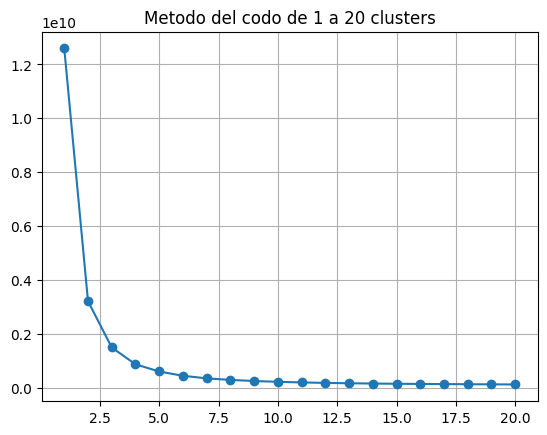

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []

clusters = list(range(1, 21))
for k in clusters:
    pipeline = Pipeline([('LRMFP', FunctionTransformer(custom_features)), \
                 ('MinMax', ColumnTransformer(transformers=[("MinMax", MinMax(), ["Frequency", "Monetary", "Periodicity"])], remainder='passthrough')), \
                 ('kmeans', KMeans(n_clusters=k))])
    kmeans = pipeline.fit(df_retail)[-1]
    sse.append(kmeans.inertia_)

plt.plot(clusters, sse, marker="o")
plt.title("Metodo del codo de 1 a 20 clusters")
plt.grid(True)
plt.show()

Respuesta: Se escoge el valor k=5 ya que a partir de ese valor el decrecimiento del SSE minimo

#### 1.3.3.2 Segmentación de Clientes con K-Means 🎁 [1 punto]

En base a la elección de k realizada en la sección anterior, utilice este valor escogido y entrene un modelo de K-means utilizando el mismo pipeline de scikit-learn utilizado anteriormente.

Una vez ajustado los datos, genere una tabla con los promedios (o medianas) para cada uno de los atributos, agrupando estos por el clúster que pertenecen. ¿Es posible observar agrupaciones coherentes?, ¿Qué tipo de clientes posee el retail?, Justifique su respuesta y no decepcione a Mr. Lepin.


In [10]:
pipeline = Pipeline([('LRMFP', FunctionTransformer(custom_features)), \
               ('MinMax', ColumnTransformer(transformers=[("MinMax", MinMax(), ["Frequency", "Monetary", "Periodicity"])], remainder='passthrough')), \
                 ('kmeans', KMeans(n_clusters=5))])
kmeans = pipeline.fit(df_retail)[-1]

df = custom_features(df_retail)
df["Cluster"] = kmeans.labels_
df.groupby("Cluster").mean()

,Length,Recency,Frequency,Monetary,Periodicity
Cluster,,,,,
0,136.123116,156.092253,4.528894,34.962761,10.814577
1,129.017957,152.274264,4.157127,54.608326,11.128184
2,135.325444,163.573394,4.592899,37.928744,12.116233
3,132.761400,156.319521,4.528102,40.507942,11.650737
4,137.007151,158.650999,4.432658,38.271931,12.488834


**Respuesta:** En general se pueden ver clusters bastante homogeneos para las variables que se examinan. Los valores estan un poco alejados de la respuesta esperada. La mayor diferencia ocurre en la columna monetaria, esto implica que los clientes en general de la tienda comenzaron al mismo tiempo, tienen la misma frecuencia y patrones de visitas, pero presentan poderes adquisitivos un tanto distintos, pero no por mucha diferencia. En general no es posible obtener mucha informacion sobre los clientes mas que son homogeneos entre ellos.

**Respuesta Esperada:**

|         | Length  | Recency   | Frequency | Monetary | Periodicity |       |
|---------|---------|-----------|----------|-------------|-------|-------|
| Cluster |         |           |          |             |       |       |
|    0    |   258.8 |      45.2 |     76.1 |      1107.7 | 107.6 |   449 |
|    1    |    76.1 |     217.6 |     45.5 |       791.7 |  14.1 |   466 |
|    2    |   368.5 |       4.8 |   2715.0 |    226621.6 |   4.2 |     4 |
|    3    |    85.3 |      45.7 |     65.8 |      1047.0 |  10.5 |   987 |
|    4    |   347.2 |      15.9 |   1658.0 |     35829.3 |   8.0 |    25 |
|    5    |   298.0 |      29.8 |    183.8 |      3639.9 |  32.0 |  1188 |

#### 1.3.3.3 Plot de K-Means 📈 [0.5 puntos]



Por último, Mr. Lepin, impaciente de no entender lo que usted intenta explicarle, le solicita que por favor muestre algún resultado "visual" de los grupos encontrados.

Para esto, grafique nuevamente las características encontradas usando `T-SNE` (no calcule de nuevo, simplemente utilice las proyecciones encontradas) y agregue las labels calculadas con kmeans como el argumento `color`.   

Comente: ¿Se separan bien los distintos clusters en la visualización?


**Respuesta:**

In [11]:
px.scatter(x=X_transformed[:, 0],y=X_transformed[:, 1],color=kmeans.labels_,title='Gráfico de clusters usando K-Means (con k=5)',width=600,height=400)


Los clusters no presentan una separacion en la visualizacion, esto se condice completamente con lo apreciado en la tabla y analisis anterior. Los clientes osn completamente homogeneos, quizas presentando distintas concentraciones en distintos puntos, pero no de manera significativa. Como la distribucion de los puntos es igual para todos, es dificil segmentarlos apropiadamente con la informacion calculada.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por correo, Discord o U-cursos.

![Gracias Totales!](https://i.pinimg.com/originals/65/ae/27/65ae270df87c3c4adcea997e48f60852.gif "bruno")


<br>
<center>
<img src="https://i.kym-cdn.com/photos/images/original/001/194/195/b18.png" width=100 height=50 />
</center>
<br>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>